In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *

In [44]:
torch.cuda.is_available()

False

In [2]:
G_21 = xr.open_dataset("../dataset/G_21_subset_imputed.nc")
G_21 = G_21.to_array().values.squeeze(0)
G_21.shape

(3565, 102484)

In [136]:
real_data_index = True
n = 1000
p = 20000
p_causal = 100
if real_data_index:
    np.random.seed(seed = None)
    p_max = G_21.shape[1]
    n_max = G_21.shape[0]
    SNP_index = np.random.choice(p_max,size = p, replace = False)
    subject_index =  np.random.choice(n_max,size = n, replace = False)
    G_21_sub = G_21[np.ix_(subject_index, SNP_index)]
    print(G_21_sub.shape)
    freq_snp = G_21_sub.mean(axis = 0)/2
    sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
    G_21_sub = (G_21_sub-2*freq_snp)/sd_snp
    Xs = [G_21_sub]
    n = Xs[0].shape[0]
    p = Xs[0].shape[1]
else:
    Xs = None

(1000, 20000)


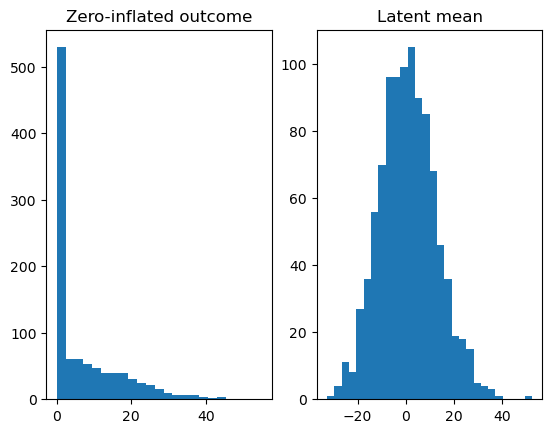

------------------------------------
genetic variance is 138.07109993434483
total variance is276.14219986868966
heritability is 0.5
------------------------------------


In [137]:
rho = 0.6
var = 1
n_matrix = 1
h = 0.5
beta_bias = 1
sim_class = data_sim.sim_tobit_data(n = n, p = p, p_causal = p_causal, rho = rho, var = var, n_matrix = n_matrix,h = h, bias = beta_bias, Xs = Xs, scale_lambda =None)
z, X, Xs, latent_mean, var_genetic, var_total, true_beta, y_star = sim_class.gen_data(seed = None)
data_sim.show_sim(z, latent_mean, var_total)

In [138]:
model = linear_slab_spike(p = p, init_pi_local = 0.1, init_pi_global = 0.1, init_beta_var = 2, init_noise_var = 1,
                         gumbel_softmax_temp = 1, gumbel_softmax_hard = True, 
                          a= 0.1, b=0.1, init_c= 0.1, init_d = 0.1,
                          q1 = 1.1, q2 = 1.1, init_q3 = 1.1, init_q4 = 1.1, n_E = 1
                         ).double()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
for i in range(5000):
    loss = -model.ELBO(X.double(),y_star.double())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        lr_scheduler.step()
        print(f'At iteration {i}, the loss is {loss.item()}')

At iteration 0, the loss is 314274.8745483818
At iteration 1000, the loss is 14625.600714365577
At iteration 2000, the loss is 13736.323316858583
At iteration 3000, the loss is 13482.958581324196
At iteration 4000, the loss is 13362.126254879788


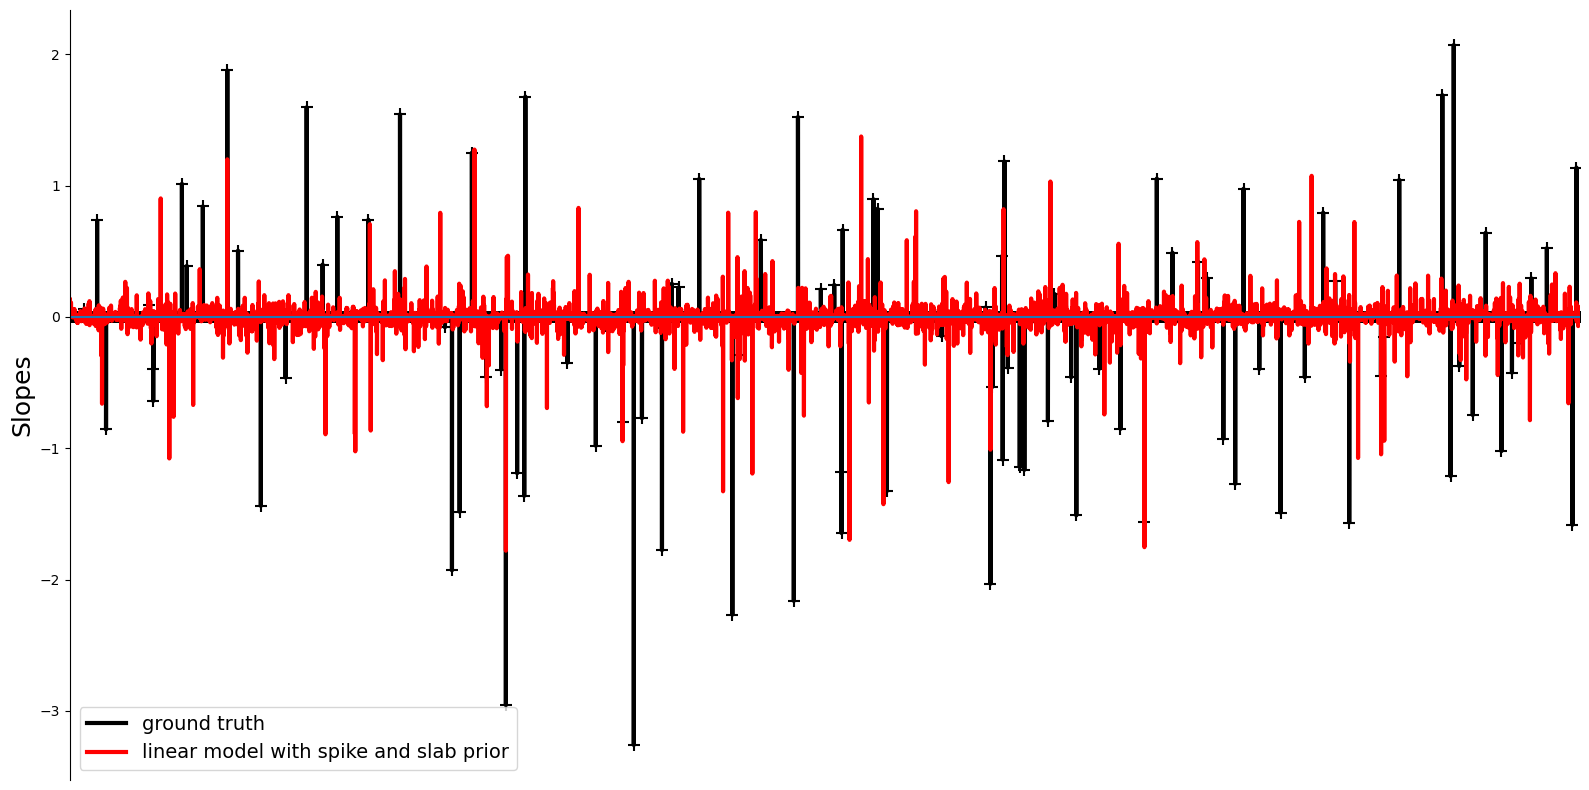

{'mean_h_est': 0.502079722244076,
 'h_est_upper': 0.6580031162576764,
 'h_est_lower': 0.3115431766205474,
 'mean_var_genetic': 196.97585170610785,
 'noise_var': 208.94141933534405,
 'global_pi': 0.056873354880907515,
 'global_pi_upper': 0.07334229377527211,
 'global_pi_lower': 0.04134163960045388}

In [139]:
model.inference(X = X.double(),  num_samples = 1000, plot = True, true_beta = true_beta)

In [131]:
p_causal/p

0.005

In [73]:
torch.sum(torch.sigmoid(model.logit_pi_local)>0.9)/p

tensor(0.)

In [74]:
print(torch.max(torch.sigmoid(model.logit_pi_local)))
print(torch.min(torch.sigmoid(model.logit_pi_local)))

tensor(0.8880, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0416, dtype=torch.float64, grad_fn=<MinBackward1>)


In [101]:
torch.exp(model.log_c)

tensor([107.5714], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [102]:
torch.exp(model.log_d)

tensor([3279.9581], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [103]:
torch.min(model.beta_mu)

tensor(-3.7905, dtype=torch.float64, grad_fn=<MinBackward1>)

In [104]:
torch.max(model.beta_mu)

tensor(2.9289, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [105]:
torch.exp(model.beta_log_var)

tensor([0.4745, 0.4918, 0.4918,  ..., 0.4856, 0.5021, 0.4912],
       dtype=torch.float64, grad_fn=<ExpBackward0>)

In [106]:
torch.mean(torch.exp(model.beta_log_var))

tensor(0.4842, dtype=torch.float64, grad_fn=<MeanBackward0>)